# Plotting

## Imports

In [1]:
import pandas as pd
import math
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seawater as sw
import cmocean.cm as cmo
from scipy import integrate
from scipy.interpolate import griddata
import gsw
import sys
import matplotlib.dates as mdates
from cartopy.io.shapereader import Reader
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')


## Load data

In [14]:
ds_id = 'ru29-20230530T1910-profile-sci-rt'

## Load flight data
variables = ['depth', 'depth_interpolated','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity', 'oxygen_concentration_shifted','source_file', 'u', 'v']
gdf23 = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf23.columns = variables

## Great way to find start and end times!!
start_times = gdf23.groupby('source_file').first().time.values
end_times   = gdf23.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(gdf23.salinity.values, gdf23.pressure.values, gdf23.longitude.values, gdf23.latitude.values)
gdf23['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, gdf23.potential_temperature.values, gdf23.pressure.values)
gdf23['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
gdf23['sigma0'] = sigma0

gdf23


,depth,depth_interpolated,pressure,latitude,longitude,time,potential_temperature,salinity,oxygen_concentration_shifted,source_file,u,v,absolute_salinity,conservative_temperature,sigma0
0,5.129888,5.129888,5.16,14.549578,-61.113453,2023-05-30T19:56:47.49Z,28.423769,35.509907,197.692,ru29-2023-149-4-0-sbd(06740000),NaN,NaN,35.677890,28.408084,1022.639724
1,7.873728,7.873728,7.92,14.549570,-61.113498,2023-05-30T19:57:03.54Z,28.399712,35.511776,197.773,ru29-2023-149-4-0-sbd(06740000),NaN,NaN,35.679784,28.383250,1022.649319
2,11.392948,11.392948,11.46,14.549562,-61.113543,2023-05-30T19:57:19.60Z,28.384167,35.507652,197.914,ru29-2023-149-4-0-sbd(06740000),NaN,NaN,35.675641,28.367007,1022.651642
3,NaN,13.192292,NaN,14.549558,-61.113565,2023-05-30T19:57:27.25Z,NaN,NaN,NaN,ru29-2023-149-4-0-sbd(06740000),NaN,NaN,NaN,NaN,NaN
4,14.991636,14.991636,15.08,14.549554,-61.113588,2023-05-30T19:57:35.66Z,28.359106,35.505535,NaN,ru29-2023-149-4-0-sbd(06740000),NaN,NaN,35.673486,28.341133,1022.658599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250423,NaN,7.777626,NaN,14.549106,-61.113329,2023-06-26T18:27:37.07Z,NaN,NaN,NaN,ru29-2023-176-0-2-sbd(06760002),NaN,NaN,NaN,NaN,NaN
250424,NaN,7.005509,NaN,14.549105,-61.113320,2023-06-26T18:27:41.72Z,NaN,NaN,NaN,ru29-2023-176-0-2-sbd(06760002),NaN,NaN,NaN,NaN,NaN
250425,6.233393,6.233393,6.27,14.549105,-61.113315,2023-06-26T18:27:44.38Z,28.872389,35.076280,NaN,ru29-2023-176-0-2-sbd(06760002),NaN,NaN,35.242218,28.875515,1022.165003
250426,NaN,5.085148,NaN,14.549104,-61.113311,2023-06-26T18:27:46.35Z,NaN,NaN,NaN,ru29-2023-176-0-2-sbd(06760002),NaN,NaN,NaN,NaN,NaN


In [10]:
ds_id = 'ru29-20221116T1326-profile-sci-delayed'

## Load flight data
variables = ['depth', 'depth_interpolated','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity', 'oxygen_concentration_shifted','source_file', 'u', 'v']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

# ########## Convert variables for calculations
# ## Absolute salinity
# SA = gsw.SA_from_SP(gdf.salinity.values, gdf.depth.values, gdf.longitude.values, gdf.latitude.values)
# gdf['absolute_salinity'] = SA
# ## Conservative temperature
# CT = gsw.CT_from_t(SA, gdf.potential_temperature.values, gdf.depth.values)
# ## Potential density
# sigma0  = gsw.sigma0(SA,CT)+1000
# gdf['sigma0'] = sigma0



## Absolute salinity
SA = gsw.SA_from_SP(gdf.salinity.values, gdf.pressure.values, gdf.longitude.values, gdf.latitude.values)
gdf['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, gdf.potential_temperature.values, gdf.pressure.values)
gdf['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
gdf['sigma0'] = sigma0

gdf

,depth,depth_interpolated,pressure,latitude,longitude,time,potential_temperature,salinity,oxygen_concentration_shifted,source_file,u,v,absolute_salinity,conservative_temperature,sigma0
0,0.009942,0.009942,0.01,14.534225,-61.105686,2022-11-16T13:29:51.41Z,28.380598,35.108273,NaN,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,35.274327,28.382841,1022.351785
1,NaN,0.044738,NaN,14.534223,-61.105687,2022-11-16T13:29:52.97Z,NaN,NaN,194.861,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,NaN,NaN,NaN
2,0.079534,0.079534,0.08,14.534221,-61.105692,2022-11-16T13:29:54.48Z,28.377481,35.109300,NaN,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,35.275360,28.379658,1022.353591
3,0.069592,0.069592,0.07,14.534217,-61.105700,2022-11-16T13:29:56.48Z,28.377384,35.109097,NaN,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,35.275156,28.379572,1022.353470
4,NaN,0.056337,NaN,14.534215,-61.105705,2022-11-16T13:29:57.88Z,NaN,NaN,194.840,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120890,NaN,1.347106,NaN,14.536617,-61.101049,2022-12-07T18:15:33.93Z,NaN,NaN,195.661,ru29-2022-336-0-77-dbd(06610077),NaN,NaN,NaN,NaN,NaN
1120891,1.193009,1.193009,1.20,14.536618,-61.101051,2022-12-07T18:15:34.94Z,28.244514,35.652910,NaN,ru29-2022-336-0-77-dbd(06610077),NaN,NaN,35.821547,28.223542,1022.806103
1120892,NaN,1.090278,NaN,14.536619,-61.101052,2022-12-07T18:15:35.95Z,NaN,NaN,195.496,ru29-2022-336-0-77-dbd(06610077),NaN,NaN,NaN,NaN,NaN
1120893,NaN,0.987547,NaN,14.536620,-61.101053,2022-12-07T18:15:36.40Z,NaN,NaN,NaN,ru29-2022-336-0-77-dbd(06610077),NaN,NaN,NaN,NaN,NaN


In [11]:
dominica_df = gdf[(gdf.time>= '2022-11-18T12:00:00Z') & (gdf.time<='2022-11-21T13:00:00Z')]
stluc_df1 = gdf[(gdf.time>= '2022-11-24T05:00:00Z') & (gdf.time<='2022-11-25T15:30:00Z')]
stluc_df2 = gdf[(gdf.time>= '2022-12-03T09:30:00Z') & (gdf.time<='2022-12-04T07:00:00Z')]
stvin_df = gdf[(gdf.time>= '2022-11-27T08:00:00Z') & (gdf.time<='2022-12-01T04:00:00Z')]


In [12]:
fname = 'https://www.ngdc.noaa.gov/thredds/dodsC/global/ETOPO2022/30s/30s_bed_elev_netcdf/ETOPO_2022_v1_30s_N90W180_bed.nc'
ds_etpo = xr.open_dataset(fname)
ds_etpo

<xarray.Dataset>
Dimensions:  (lat: 21600, lon: 43200)
Coordinates:
  * lat      (lat) float64 -90.0 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99 90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    crs      |S64 ...
    z        (lat, lon) float32 ...
Attributes:
    GDAL_AREA_OR_POINT:             Area
    node_offset:                    1
    GDAL_TIFFTAG_COPYRIGHT:         DOC/NOAA/NESDIS/NCEI > National Centers f...
    GDAL_TIFFTAG_DATETIME:          20220929123913.0
    GDAL_TIFFTAG_IMAGEDESCRIPTION:  Topography-Bathymetry; EGM2008 height
    Conventions:                    CF-1.5
    GDAL:                           GDAL 3.3.2, released 2021/09/01
    NCO:                            netCDF Operators version 4.9.1 (Homepage ...
    _NCProperties:                  version=2,netcdf=4.8.1,hdf5=1.12.1
    DODS.strlen:                    0

## Plot it up!

/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/joegradone/opt/anaconda3/lib/python3.7/

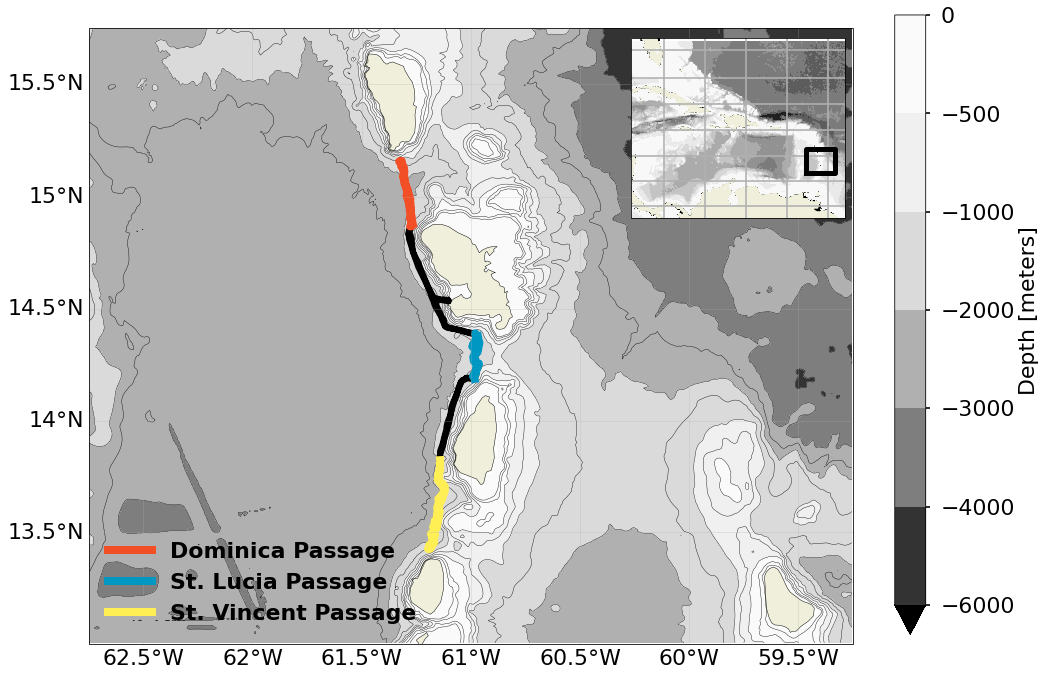

In [13]:
fig, ax = plt.subplots(figsize=(15, 20), subplot_kw=dict(projection=ccrs.Mercator()))

## Map extent
lon1 = -62.75
lon2 = -59.25
lat1 = 13
lat2 = 15.75

ax.set_extent([lon1, lon2, lat1, lat2])
## Isobars to plot
lvl = [-4000, -3000, -2500, -2000, -1500, -1000, -750, -500, -250, -100]

## Depth contours to plot
#dpth_contours = np.array([-6500, -5000,-4000, -3000, -2000, -1000,0])

dpth_contours = np.array([-6000,-4000, -3000, -2000, -1000,-500,0])

## Subset bathymetry
#region = ds_etpo.sel(x=slice(lon1, lon2), y=slice(lat1, lat2))
region = ds_etpo.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))

# bathy = ax.contourf(region.x, region.y, region.z,levels=50,  cmap='Blues_r' ,  transform=ccrs.PlateCarree(), vmin=-3000, vmax=0, zorder=0)
# bathy = ax.contourf(region.x, region.y, region.z,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), levels=dpth_contours, zorder=0)
# ax.contour(region.x, region.y, region.z, levels= lvl, colors='k', linestyles='solid', linewidths=.4,  transform=ccrs.PlateCarree())
bathy = ax.contourf(region.lon, region.lat, region.z,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), levels=dpth_contours, zorder=0, extend="min")
ax.contour(region.lon, region.lat, region.z, levels= lvl, colors='k', linestyles='solid', linewidths=.4,  transform=ccrs.PlateCarree())


LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor=cfeature.COLORS['land']
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}
#glb.ylocator = mticker.FixedLocator([17, 17.25, 17.5, 17.75, 18, 18.25, 18.5, 18.75])
#glb.xlocator = mticker.FixedLocator([-65.5,-65,-64.5,-64])


dominica_color = '#f24f26'
st_lucia_color = '#0097c3'
st_vincent_color = '#ffef55'

ax.plot(gdf.longitude, gdf.latitude,linewidth=6, linestyle='-',transform=ccrs.PlateCarree(), color='black')

ax.plot(dominica_df.longitude, dominica_df.latitude,linewidth=8, linestyle='-',transform=ccrs.PlateCarree(), color=dominica_color, label='Dominica Passage')
ax.plot(stluc_df1.longitude, stluc_df1.latitude,linewidth=8, linestyle='-',transform=ccrs.PlateCarree(), color=st_lucia_color, label='St. Lucia Passage')
ax.plot(stluc_df2.longitude, stluc_df2.latitude,linewidth=8, linestyle='-',transform=ccrs.PlateCarree(), color=st_lucia_color)
ax.plot(stvin_df.longitude, stvin_df.latitude,linewidth=8, linestyle='-',transform=ccrs.PlateCarree(), color=st_vincent_color, label='St. Vincent Passage')


cbar = plt.colorbar(bathy,pad=0.05, fraction=0.037)
cbar.set_label(label='Depth [meters]', size=22)
cbar.ax.tick_params(labelsize=22)

## Add a small, zoomed out map for context
## bbox_to_anchor(left, bottom, width, height)
axins = inset_axes(ax, width="28%", height="50%",
                   bbox_to_anchor=(0, 0.1, 1, 1),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes,
                   axes_kwargs=dict(map_projection=ccrs.Mercator(central_longitude=-65.5)))

## Extent of inset map
lon1_big = -84
lon2_big = -58
lat1_big = 7.5
lat2_big = 28
axins.set_extent([lon1_big, lon2_big, lat1_big, lat2_big])

## Box around actual figure region
axins.plot([lon1, lon1,  lon2, lon2, lon1] , 
                        [lat1, lat2, lat2, lat1, lat1 ], color='black',linewidth=5,  transform=ccrs.PlateCarree(), zorder=100 )
axins.add_feature(LAND, zorder=0,linewidths=1)
axins.gridlines(linewidths=.5)

region = ds_etpo.sel(lon=slice(lon1_big, lon2_big), lat=slice(lat1_big, lat2_big))

## Similar to the main plot but just a tad deeper
dpth_contours = np.array([-9000,-7000,-5750,-5000,-4250,-3500,-2750,-2000, -1000,0])

## inset bathy
axins.contourf(region.lon, region.lat, region.z,levels=dpth_contours,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), zorder=0)

leg = ax.legend(loc='lower left', frameon= False,prop={'size': 22, 'weight':'bold'})

#plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/Windward_Passages_2022_Glider_Deployment_Plots/RU29_2022_Map_Colored_by_EEZs.png', bbox_inches='tight',dpi=300,facecolor='white')



In [6]:
## indexes for layers for plotting
surface_ind       = np.where(gdf.sigma0.values < 1024.5)[0]
salinity_max_ind  = np.where((gdf.sigma0.values >= 1024.5) & (gdf.sigma0.values < 1026.3))[0]
central_water_ind = np.where((gdf.sigma0.values >= 1026.3) & (gdf.sigma0.values < 1027.1))[0]
int_water_ind     = np.where((gdf.sigma0.values >= 1027.1))[0]


## Change this to conservative temperature and absolute salinity

In [9]:
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# cmap = matplotlib.cm.get_cmap('viridis')

# fig, axs = plt.subplots(3, 1, figsize=(10, 30))

# font_size = 26

# axs[0].plot(gdf.potential_temperature,gdf.depth,'.',color='black')
# axs[0].grid()
# axs[0].tick_params(axis='both', which='major', labelsize=font_size)
# axs[0].set_xlabel('Potential Temperature [°C]',fontsize=font_size)
# axs[0].set_ylabel('Depth [meters]',fontsize=font_size)
# axs[0].set_xlim(3,31)
# axs[0].set_ylim(1000,0)
# axs[0].text(0.005,0.94,'(a)', transform=axs[0].transAxes, size=font_size, weight='bold')

# axs[1].plot(gdf.salinity,gdf.depth,'.',color='black')
# axs[1].grid()
# axs[1].tick_params(axis='both', which='major', labelsize=font_size)
# axs[1].set_xlabel('Salinity [PSU]',fontsize=font_size)
# axs[1].set_ylabel('Depth [meters]',fontsize=font_size)
# axs[1].set_xlim(34,37.5)
# axs[1].set_ylim(1000,0)
# axs[1].text(0.005,0.94,'(b)', transform=axs[1].transAxes, size=font_size, weight='bold')

# axs[2].plot(gdf.salinity[surface_ind],gdf.potential_temperature[surface_ind],'.',label='Surface Water',color=cmap(0.999))
# axs[2].plot(gdf.salinity[salinity_max_ind],gdf.potential_temperature[salinity_max_ind],'.',label='Salinity Maximum Water',color=cmap(0.666))
# axs[2].plot(gdf.salinity[central_water_ind],gdf.potential_temperature[central_water_ind],'.',label='Central Water',color=cmap(0.333))
# axs[2].plot(gdf.salinity[int_water_ind],gdf.potential_temperature[int_water_ind],'.',label='Intermediate Water',color=cmap(0.001))

# axs[2].tick_params(axis='both', which='major', labelsize=font_size)
# axs[2].set_ylabel('Potential Temperature [°C]',fontsize=font_size)
# axs[2].set_xlabel('Salinity [PSU]',fontsize=font_size)
# axs[2].set_ylim(3,31)
# axs[2].set_xlim(34,37.5)    
# axs[2].grid()
# axs[2].text(0.005,0.94,'(c)', transform=axs[2].transAxes, size=font_size, weight='bold')
# axs[2].legend(fontsize=font_size,markerscale=4,frameon=False,markerfirst=False,loc='lower right',handletextpad=-0.25, labelspacing=0.05,borderaxespad=-0.4)


# plt.savefig('./plots/Windwards_Dominant_Water_Masses.png', bbox_inches='tight',dpi=300,facecolor='white')


/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part ge

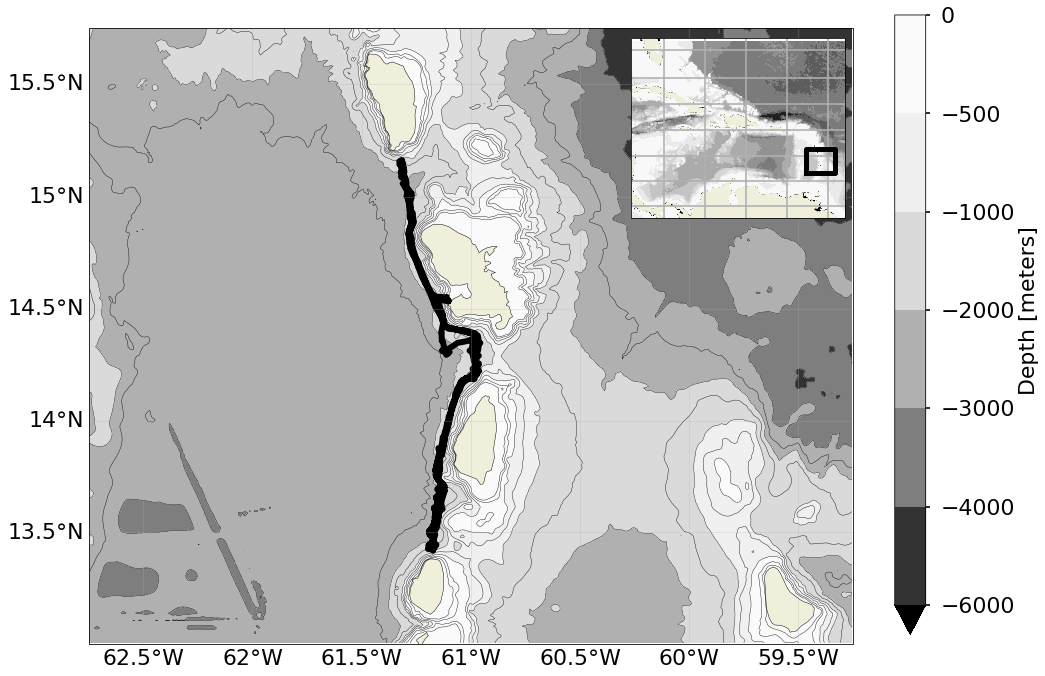

In [16]:
fig, ax = plt.subplots(figsize=(15, 20), subplot_kw=dict(projection=ccrs.Mercator()))

## Map extent
lon1 = -62.75
lon2 = -59.25
lat1 = 13
lat2 = 15.75

ax.set_extent([lon1, lon2, lat1, lat2])
## Isobars to plot
lvl = [-4000, -3000, -2500, -2000, -1500, -1000, -750, -500, -250, -100]

## Depth contours to plot
#dpth_contours = np.array([-6500, -5000,-4000, -3000, -2000, -1000,0])

dpth_contours = np.array([-6000,-4000, -3000, -2000, -1000,-500,0])

## Subset bathymetry
#region = ds_etpo.sel(x=slice(lon1, lon2), y=slice(lat1, lat2))
region = ds_etpo.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))

# bathy = ax.contourf(region.x, region.y, region.z,levels=50,  cmap='Blues_r' ,  transform=ccrs.PlateCarree(), vmin=-3000, vmax=0, zorder=0)
# bathy = ax.contourf(region.x, region.y, region.z,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), levels=dpth_contours, zorder=0)
# ax.contour(region.x, region.y, region.z, levels= lvl, colors='k', linestyles='solid', linewidths=.4,  transform=ccrs.PlateCarree())
bathy = ax.contourf(region.lon, region.lat, region.z,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), levels=dpth_contours, zorder=0, extend="min")
ax.contour(region.lon, region.lat, region.z, levels= lvl, colors='k', linestyles='solid', linewidths=.4,  transform=ccrs.PlateCarree())


LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor=cfeature.COLORS['land']
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}
#glb.ylocator = mticker.FixedLocator([17, 17.25, 17.5, 17.75, 18, 18.25, 18.5, 18.75])
#glb.xlocator = mticker.FixedLocator([-65.5,-65,-64.5,-64])



ax.plot(gdf.longitude, gdf.latitude,linewidth=6, linestyle='-',transform=ccrs.PlateCarree(), color='black')
ax.plot(gdf23.longitude, gdf23.latitude,linewidth=6, linestyle='-',transform=ccrs.PlateCarree(), color='black')


cbar = plt.colorbar(bathy,pad=0.05, fraction=0.037)
cbar.set_label(label='Depth [meters]', size=22)
cbar.ax.tick_params(labelsize=22)

## Add a small, zoomed out map for context
## bbox_to_anchor(left, bottom, width, height)
axins = inset_axes(ax, width="28%", height="50%",
                   bbox_to_anchor=(0, 0.1, 1, 1),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes,
                   axes_kwargs=dict(map_projection=ccrs.Mercator(central_longitude=-65.5)))

## Extent of inset map
lon1_big = -84
lon2_big = -58
lat1_big = 7.5
lat2_big = 28
axins.set_extent([lon1_big, lon2_big, lat1_big, lat2_big])

## Box around actual figure region
axins.plot([lon1, lon1,  lon2, lon2, lon1] , 
                        [lat1, lat2, lat2, lat1, lat1 ], color='black',linewidth=5,  transform=ccrs.PlateCarree(), zorder=100 )
axins.add_feature(LAND, zorder=0,linewidths=1)
axins.gridlines(linewidths=.5)

region = ds_etpo.sel(lon=slice(lon1_big, lon2_big), lat=slice(lat1_big, lat2_big))

## Similar to the main plot but just a tad deeper
dpth_contours = np.array([-9000,-7000,-5750,-5000,-4250,-3500,-2750,-2000, -1000,0])

## inset bathy
axins.contourf(region.lon, region.lat, region.z,levels=dpth_contours,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), zorder=0)

leg = ax.legend(loc='lower left', frameon= False,prop={'size': 22, 'weight':'bold'})


